In [128]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import tqdm
import copy
import gc

First lets define a simple harmonic well to serve as a base potential for our system to sample.

We will need to define functions for both the potential and its derivative.

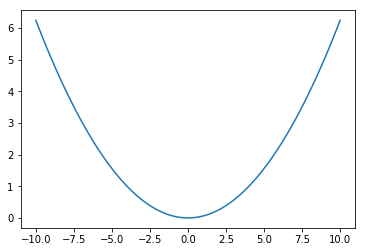

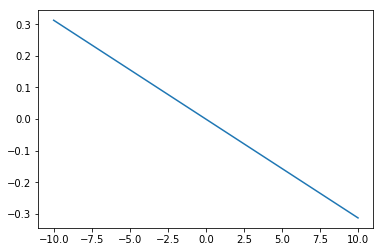

In [129]:
xVals=np.linspace(-10,10,100)
potFun=lambda x: (x/4.0)**2

potDer=lambda x: -x/(2*4.0**2)

yVals=potFun(xVals)

plt.plot(xVals,yVals)
plt.show()

plt.plot(xVals,potDer(xVals))
plt.show()

A simple leapfrog integrator will be used to run the simulation.

It takes a starting position and initial velocity as input.

It returns a tuple of arrays containing the x coordinate, velocity, force, and energy of the particle(s) at each time step... This function could potentially handle a set of any number of non-interacting particles, but for the moment we will only simulate a single particle in our potential distribution in order to get some test data.

In [130]:
def run_sim2(xinit,vinit,fFun,pFun,nsteps,dt=.001):
    xvals=np.zeros(nsteps)
    vvals=np.zeros(nsteps)
    fvals=np.zeros(nsteps)
    Evals=np.zeros(nsteps)
    xi=xinit
    vi=vinit
    xvals[0]=xinit
    vvals[0]=vinit
    fvals[0]=fFun(xinit)
    for iStep in tqdm.tqdm_notebook(np.arange(nsteps-1)):
        fi=fFun(xinit)
        vp=vi+fFun(xi)*dt
        xp=xi+dt*vp
        Evals[iStep]=Evals[iStep]+.5*(pFun(xi)+(vi+vp/2.0)**2)
        xvals[iStep+1]=xp
        vvals[iStep+1]=vp
        fvals[iStep+1]=fFun(xp)
        xi=xp
        vi=vp
    Evals[-1]=3./4.*(pFun(xvals[-1])+vvals[-1]**2)
    return (xvals,vvals,fvals,Evals)

Lets run a test first (no milestoning wells) to make sure we get the expected behaviour under the base potential.

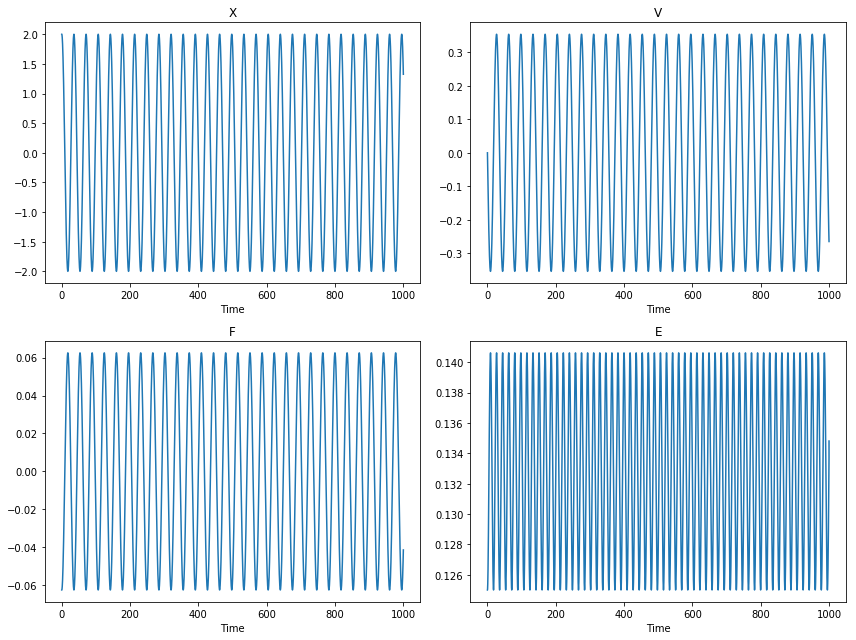

In [131]:
ts=.01
simDat=run_sim2(2.0,0.0,potDer,potFun,100000,dt=ts)
times=np.arange(len(simDat[0]))*ts
fig,axs=plt.subplots(2,2)
fig.set_figheight(9)
fig.set_figwidth(12)
setNames=["X","V","F","E"]
for iSet,dataSet in enumerate(simDat):
    ax=axs.flat[iSet]
    ax.plot(times,dataSet)
    ax.set_xlabel("Time")
    ax.set_title(setNames[iSet])
plt.tight_layout()
plt.show()

There seems to be a small ringing in the energy but no apparent drift.
The oscilation in other values is as expected. Note that X and V give exhibit the expected quarter cycle phase shift in their oscilations while F and X exhibit the expected half cycle phase shift.

We will now set up milestoning to sample our potential well over the range [-4.5,4.5] with well widths of 1 unit and a force constant of 10. The force constant of the well itself is 1/32.0, so the sample wells are effectively hard wall like compared with the underlying potential sampled.

To start we define two functions below that will generate appropriate milestoning wells for each window center.

In [132]:
def get_window_potential_function(xmin,xmax,k,pFun):
    return lambda x: k*((x>xmax)*(x-xmax)**2+(x<xmin)*(x-xmin)**2)+pFun(x)

def get_window_pDeriv_function(xmin,xmax,k,pDer):
    return lambda x: k*((x<xmin)*(xmin-x)+(x>xmax)*(xmax-x))+pDer(x)

Lets plot the potential and force for each well window to make sure they are working right.

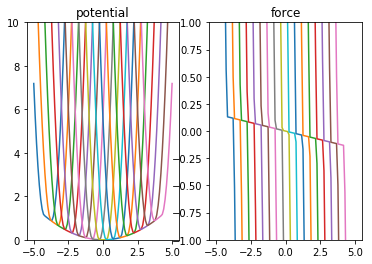

In [133]:
windowWidth=.5
windowK=10.0
windowCenters=np.arange(-8,9)*windowWidth
winMaxs=windowCenters+windowWidth/2.0
winMins=windowCenters-windowWidth/2.0

window_potFuns=[
    get_window_potential_function(
        winMins[iWin],winMaxs[iWin],windowK,potFun) \
    for iWin,win in enumerate(windowCenters)]
window_pDerFuns=[
    get_window_pDeriv_function(
        winMins[iWin],winMaxs[iWin],windowK,potDer) \
    for iWin,win in enumerate(windowCenters)]

xvals=np.linspace(-5,5,100)
fig,axs=plt.subplots(1,2)
axs.flat[0].set_title('potential')
axs.flat[0].set_ylim(0,10.0)
axs.flat[1].set_title('force')
axs.flat[1].set_ylim(-1,1)
for iWin,win in enumerate(windowCenters):
    ax=axs.flat[0]
    ax.plot(xvals,window_potFuns[iWin](xvals),label='center=%.2f'%win)
    ax=axs.flat[1]
    ax.plot(xvals,window_pDerFuns[iWin](xvals),label='center=%.2f'%win)
plt.show()

In [156]:
zip(enumerate(windowCenters))

[((0, -4.0),),
 ((1, -3.5),),
 ((2, -3.0),),
 ((3, -2.5),),
 ((4, -2.0),),
 ((5, -1.5),),
 ((6, -1.0),),
 ((7, -0.5),),
 ((8, 0.0),),
 ((9, 0.5),),
 ((10, 1.0),),
 ((11, 1.5),),
 ((12, 2.0),),
 ((13, 2.5),),
 ((14, 3.0),),
 ((15, 3.5),),
 ((16, 4.0),)]

# Test Milestoning Simulation
We will now run a simulation for each window and collect the results into a joint data table.

Each simulation will be run for a total of 100k steps and subsampled every 500 steps, to emulate a more typical simulation result.

We will use a finer timestep here due to the steepness of the milestoning well potentials.

We start the particle at the center of each well.

We give a starting velocity of .5 units, moving against the potential gradient at the center of the current window well.


In [151]:
simDataTables=[]
nSteps=100000
sampleRate=500
dt=.001
vfac=.28
for iWin,win in enumerate(windowCenters):
    print 'running window %g; center = %.4f'%(iWin,win)
    winPotFun=window_potFuns[iWin]
    winPotDer=window_pDerFuns[iWin]
    vstart=vfac*np.sign(.5-np.random.random()) if winPotFun(win)==0 else np.sign(winPotDer(win))*vfac
    #initial velocity of 1 unit moving against potential gradient
    #if gradient is 0 randomly choose left or right
    xstart=win #start at random point near window center
    simData=run_sim2(xstart,vstart,winPotDer,winPotFun,nSteps,dt=ts)
    frames=np.arange(nSteps)[(sampleRate-1)::sampleRate]
    nFrames=len(frames)
    times=np.arange(nSteps)[(sampleRate-1)::sampleRate]*dt
    tempTable=pd.DataFrame({
        "Window":['%02g'%iWin]*nFrames,
        "Frame":frames,
        "Time":times,
        "X":simData[0][(sampleRate-1)::sampleRate],
        "V":simData[1][(sampleRate-1)::sampleRate],
        "F":simData[2][(sampleRate-1)::sampleRate],
        "E":simData[3][(sampleRate-1)::sampleRate]
    },columns=["Window",'Frame','Time','X','V','F','E'])
    simDataTables.append(copy.deepcopy(tempTable))
    gc.collect()
    
simData=()
gc.collect()

simDataTable=pd.concat(simDataTables)
simDataTables=[]
simDataTable.to_csv("Test_Simulation_Milestoning_Data.csv",index=False)
print "X=particle coordinate; V=velocity; F=force; E=total energy (potential + kinetic)"
simDataTable.head()

running window 0; center = -4.0000


running window 1; center = -3.5000


running window 2; center = -3.0000


running window 3; center = -2.5000


running window 4; center = -2.0000


running window 5; center = -1.5000


running window 6; center = -1.0000


running window 7; center = -0.5000


running window 8; center = 0.0000


running window 9; center = 0.5000


running window 10; center = 1.0000


running window 11; center = 1.5000


running window 12; center = 2.0000


running window 13; center = 2.5000


running window 14; center = 3.0000


running window 15; center = 3.5000


running window 16; center = 4.0000


X=particle coordinate; V=velocity; F=force; E=total energy (potential + kinetic)


,Window,Frame,Time,X,V,F,E
0,00,499,0.499,-4.194121,0.169740,0.131066,0.582288
1,00,999,0.999,-4.275652,-0.031547,0.390135,0.575607
2,00,1499,1.499,-4.167321,-0.190520,0.130229,0.583354
3,00,1999,1.999,-3.959980,-0.298505,0.123749,0.590011
4,00,2499,2.499,-3.670802,-0.304773,-0.677272,0.558500


Lets plot the results to see if they make sense.

We will use the 'Bokeh' plotting package here to allow interactive inspection of the data.

In [152]:
import bokeh
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource, CDSView, GroupFilter, HoverTool
from bokeh.plotting import figure, show
from bokeh.transform import factor_cmap
from bokeh.palettes import Spectral11

from bokeh.models.mappers import CategoricalColorMapper

In [153]:
bokeh.io.output_notebook()
plotData=simDataTable
view1=CDSView(source=ColumnDataSource(plotData))

plot_size_and_tools={'plot_height':640,
                     'plot_width':640,
                     'tools':['pan','wheel_zoom','xwheel_zoom',
                              'undo','redo','reset','save',
                              'crosshair','hover']}

xCol="Time"
yCol="X"
colorCol="Window"

colorLabels=list(plotData[colorCol].unique())

p1=figure(**plot_size_and_tools)
p1.background_fill_color="black"
p1.background_fill_alpha=.75
p1.xaxis.axis_label="Time (ns)"
p1.yaxis.axis_label="RD_Lock_Distance (Å)"
for iSys,sysType in enumerate(colorLabels):
    colorVal=Spectral11[iSys%11]
    source=ColumnDataSource(plotData[plotData[colorCol]==sysType])
    p1.line(x=xCol,y=yCol,
              source=source,
              color=colorVal,alpha=.75,legend=sysType)
p1.legend.orientation="vertical"
hover = p1.select(dict(type=HoverTool))
hover.tooltips = [(colName,"@{"+colName+"}") for colName in plotData.columns]
show(p1)

Loading BokehJS ...

In [ ]:
for window in np.sort(simDataTable.Window.unique()):
    

In [169]:
np.savetxt("tmp.traj",X=np.array(simDataTable[simDataTable.Window=="00"][['Frame','X']],dtype=float),
           fmt=['%g','%f'])